<img style="float: right;" src="imgs/unifor.jpg" width="150px">

# **Política no Twitter**

Usamos redes sociais para estabelecer contatos, exposição profissional e expressar opiniões. Redes como [Twitter](https://twitter.com](https://twitter.com/) e [Facebook](https://www.facebook.com/) recebem diariamente milhões de postagens e comentários de seus usuários. Considerando esse cenário, _seria possível observar padrões de comportamento em mensagens postadas no Twitter?_

Este Notebook analisa dados da conta de dois políticos brasileiros, [Lula](https://twitter.com/LulaOficial) e [Jair Bolsonaro](https://twitter.com/jairbolsonaro) na tentativa de identificar esses padrões. 

Trabalho como resultado de Projeto da disciplina de **Introdução a Ciência de Dados**.

## **Ambiente**
Utilizamos [Python](https://www.python.org/) no ambiente [Jupyter](https://jupyter.org/) para desenvolver os Notebooks.

Para montar o ambiente de execução você precisará de uma versão do [Conda](https://sandbox.anaconda.com/) e opcionalmente o [Git](https://git-scm.com/). Você encontrará instrução de instalação desses produtos em seus próprios sites.

```bash
git clone https://github.com/michelav/projeto-twitter.git
cd projeto-twitter
source path_to_conda/activate
conda env create -f environment.yml
conda activate ptwitter
jupyter-lab
```

## **Dados**

O _dataset_ contém todos os tweets publicados pelos dois políticos até o fim de 2019. Esses tweets estão divididos em dois (um para cada político) arquivos texto no formato ```json```. Os arquivos foram extraídos por meio da API Web da plataforma e seguem o formato definido no [_hotsite_](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json) da API.

## **Análise Exploratória**

Para a análise exploratória utilizaremos a biblioteca Pandas. Ele permite que organizemos os dados em _frames_ que permitem consulta, agregação e processamento massivo de dados.

In [1]:
import pandas as pd
import numpy as np

A API de I/O do Pandas fornece um conjunto vasto de métodos para leitura (_readers_) e escrita (_writers_) de dados  (texto, binários, dados hierárquicos, etc). Há um leitor específico para o formato json acessível pela operação ```pd.read_json```. Os detalhes sobe leitura e escrita de dados em json estão disponíveis no guia de usuário do pandas, na [seção específica](https://pandas.pydata.org/docs/user_guide/io.html#json) para o formato.

<div class="alert alert-block alert-info">
    <b>Importante:</b> Fique atento ao tamanho do _dataset_ e a forma de carga e processamento de dados no Pandas. Os leitores de dados do Pandas fazem inferência sobre o tipo da informação encontrada no dado e, em algumas siuações, fazer conversões inadequadas (e lentas) durante a carga desse dado.</div>

Para esse trabalho, decidimos utilizar a API do Python para fazer a leitura e conversão dos dados (por exemplo, ```str``` para ```datetime```). 
O Processo de leitura e criação do _Dataframe_ pode ser descrito nas seguintes etapas:

+ Iteração pelos arquivos existente;
+ Processamento personalisado do arquivo json (ver ```process_tweets```)
+ Criação do Dataframe para cada arquivo
+ Pequeno saneamento (remoção de colunas desnecessárias, normalização do objeto entities, etc)
+ Concatenação dos dataframes em um só

In [156]:
import os
import datetime as dt
import json
from pandas.api.types import CategoricalDtype

dfs = []
profiles = []
profile_counts = {}

# Colunas removidas e que nao serao utilizadas nesse trabalho
to_be_dropped = ['id', 'display_text_range', 'source', 
                 'in_reply_to_status_id', 'in_reply_to_status_id_str', 
                 'in_reply_to_user_id', 'in_reply_to_user_id_str', 
                 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
                 'contributors', 'is_quote_status', 'lang', 'extended_entities',
                 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink']


# object_hook para processar as strings do json como datetime
def process_tweets(dct):
    # Chaves e sub-chaves usadas para decompor as informacoes de hashtags e mencoes 
    meta = {'hashtags': 'text', 'user_mentions': 'screen_name'}
    if 'created_at' in dct:
        try:
            dct['created_at'] = dt.datetime.strptime(dct['created_at'],'%a %b %d %H:%M:%S %z %Y').replace(hour=0, minute=0, second=0, microsecond=0)
        except ValueError:
            dct['created_at'] = np.nan
    
    for k, sk in meta.items():
        # Procura pelas chaves de Meta no dicionario que represanta o Json
        if k in dct:
            # Itera pela lista de dicionarios em cada chave encontrada(ver estrutura do json) e agrega as sub-chaves em uma lista
            items = dct[k]
            dct[k] = [ivalue for item in items for ikey, ivalue in item.items() if ikey == sk] if items else np.nan
    return dct

with os.scandir('dados') as lsit:
    fit = (f for f in lsit if f.is_file())
    for f in fit:
        with open(f.path, mode='r', encoding='utf-8') as fp:
            profile = f.name.split('.')[0]
            profiles.append(profile)
            tweets = json.load(fp, object_hook=process_tweets)
            profile_counts[profile] = len(tweets)
            df = pd.DataFrame(tweets)
            
            # TODO: A remoção das colunas durante a carga do json tornaria esse processo mais rápido?
            df.drop(columns=to_be_dropped, inplace=True)
            df['tweet_len'] = df['full_text'].str.len()
            df['word_cnt'] = df['full_text'].str.count(r'\w+')
#             df['full_text'] = df['full_text'].str.replace(r'\n', ' ')
            df['profile'] = profile
            df = df.join(pd.json_normalize(df['entities']).drop(columns=['symbols', 'urls', 'media'])).drop(columns=['entities'])
            dfs.append(df)

tweets_df = pd.concat(dfs)
cat_type = CategoricalDtype(categories=profiles , ordered=True)
tweets_df['profile'] = tweets_df['profile'].astype(cat_type)

O dataframe ```tweets_df``` contém os dados carregados. Para facilitar agrupamento futuro, criaremos um índice baseado no perfil do usuário, data e id do tweet.

In [157]:
indexed_df = tweets_df.set_index(['profile', 'created_at', 'id_str'])
indexed_df.sort_index(inplace=True)

### Contagem de tweets por Perfil

In [158]:
for profile, count in profile_counts.items():
    print("Perfil: {0}, {1} tweets.".format(profile, count))
print("Total de tweets: {}.".format(sum(profile_counts.values())))

Perfil: jairbolsonaro, 6794 tweets.
Perfil: LulaOficial, 14961 tweets.
Total de tweets: 21755.


**Jair Bolsonaro**

In [159]:
indexed_df.loc['jairbolsonaro']

full_text  \
created_at                id_str                                                                   
2010-04-01 00:00:00+00:00 11398556610          Boa noite a todos @depchicolanecar @reportercrime   
                          11398669496          Me desculpem, boa noite @depchicoalencar @repo...   
                          11399072031          Os militares assumiram o governo em março de 6...   
                          11399181472          Em 64, o povo ñ suportava + greves, desordem s...   
                          11399973381          #debate64 O Governo se fez enérgico. Os q pega...   
...                                                                                          ...   
2020-01-08 00:00:00+00:00 1214931680030580737  - A partir dessa premissa (art. 7°) nota-se qu...   
                          1214931682207371266  - Não foi a Lei Orçamentária que criou o "Fund...   
                          1214931683755134977  - Do exposto, o veto aos R$ 2 bilhões, daria m...   
                          1215006428810924032  - Donald Trump e o Irã:\n\n- Nossa Constituiçã...   
                          1215029910990774272  LEI ROMEO MION/Espectro Autista\n\n- Sancionad...   

                                               truncated  retweet_count  \
created_at                id_str                                          
2010-04-01 00:00:00+00:00 11398556610              False             18   
                          11398669496              False              2   
                          11399072031              False              9   
                          11399181472              False              6   
                          11399973381              False              3   
...                                                  ...            ...   
2020-01-08 00:00:00+00:00 1214931680030580737      False            847   
                          1214931682207371266      False           1383   
                          1214931683755134977      False           1468   
                          1215006428810924032      False           7581   
                          1215029910990774272      False           6269   

                                               favorite_count  favorited  \
created_at                id_str                                           
2010-04-01 00:00:00+00:00 11398556610                      19      False   
                          11398669496                       2      False   
                          11399072031                       1      False   
                          11399181472                       1      False   
                          11399973381                       7      False   
...                                                       ...        ...   
2020-01-08 00:00:00+00:00 1214931680030580737            5309      False   
                          1214931682207371266            8330      False   
                          1214931683755134977            8877      False   
                          1215006428810924032           48230      False   
                          1215029910990774272           40861      False   

                                               retweeted possibly_sensitive  \
created_at                id_str                                              
2010-04-01 00:00:00+00:00 11398556610              False                NaN   
                          11398669496              False                NaN   
                          11399072031              False                NaN   
                          11399181472              False                NaN   
                          11399973381              False                NaN   
...                                                  ...                ...   
2020-01-08 00:00:00+00:00 1214931680030580737      False                NaN   
                          1214931682207371266      False                NaN   
                          12149

**Lula Oficial**

In [45]:
indexed_df.loc['LulaOficial']

full_text  \
created_at                id_str                                                                   
2014-09-02 00:00:00+00:00 506821309461184512   Lula acaba de chegar ao @smabc de onde começar...   
                          506822862733578240   Acompanhe notícias da caminhada também pelo @p...   
                          506829483031425024   Lula visita o @smabc e cumprimenta sindicalist...   
                          506830992154562560   @dilmabr e Lula saem agora pelas ruas de São B...   
                          506833131694206976   "Os trabalhadores estão com @dilmabr ",  diz o...   
...                                                                                          ...   
2020-01-08 00:00:00+00:00 1214911118357016578  Na relação internacional sempre são dois inter...   
                          1214913998346424323  Vamos ter que brigar muito para o Brasil recup...   
                          1214917269769347075  Agora inventaram uma palavra pra justificar o ...   
                          1215010265638604800  Bolsonaro, pensa no Brasil e pare de ser puxa ...   
                          1215011693429952512           Nota à imprensa: https://t.co/tU7cnfrmk5   

                                               truncated  retweet_count  \
created_at                id_str                                          
2014-09-02 00:00:00+00:00 506821309461184512       False             25   
                          506822862733578240       False             14   
                          506829483031425024       False              2   
                          506830992154562560       False              3   
                          506833131694206976       False              9   
...                                                  ...            ...   
2020-01-08 00:00:00+00:00 1214911118357016578      False           3165   
                          1214913998346424323      False            996   
                          1214917269769347075      False           2428   
                          1215010265638604800      False           8812   
                          1215011693429952512      False           1108   

                                               favorite_count  favorited  \
created_at                id_str                                           
2014-09-02 00:00:00+00:00 506821309461184512               10      False   
                          506822862733578240                4      False   
                          506829483031425024                3      False   
                          506830992154562560                0      False   
                          506833131694206976                3      False   
...                                                       ...        ...   
2020-01-08 00:00:00+00:00 1214911118357016578           19479      False   
                          1214913998346424323            6428      False   
                          1214917269769347075           12574      False   
                          1215010265638604800           39979      False   
                          1215011693429952512            4708      False   

                                               retweeted possibly_sensitive  \
created_at                id_str                                              
2014-09-02 00:00:00+00:00 506821309461184512       False                NaN   
                          506822862733578240       False                NaN   
                          506829483031425024       False                NaN   
                          506830992154562560       False                NaN   
                          506833131694206976       False                NaN   
...                                                  ...                ...   
2020-01-08 00:00:00+00:00 1214911118357016578      False                NaN   
                          1214913998346424323      False                NaN   
                          12149

### Processamento dos tweets

Nessa etapa, utilizamos a biblioteca [Spacy](https://spacy.io/) para o processamento de linguagem natural, identificação de palavras relevantes, remoção de _emoticons_ e _stop words_. Antes de executar o código, é obrigatório importar o módulo da língua portuguesa disponível.

```shell
python -m spacy download pt_core_news_sm
```



In [172]:
import pt_core_news_sm
import spacy
from spacy.tokens import Token
from spacymoji import Emoji

# Regras para desconsiderar tags e mentions na contagem de palavras
is_hashtag_getter = lambda token: len(token.text) > 1 and token.text.startswith('#')
is_mention_getter = lambda token: len(token.text) > 1 and token.text.startswith('@')
is_currency_getter = lambda token: token.text.lower() == 'r$'
is_abrev_getter = lambda token: len(token.text) <= 2 and token.text.lower() in ['c/', 'p/', 'q']

Token.set_extension("is_hashtag", getter=is_hashtag_getter, force=True)
Token.set_extension("is_mention", getter=is_mention_getter, force=True)
Token.set_extension("is_currency", getter=is_currency_getter, force=True)
Token.set_extension("is_abrev", getter=is_abrev_getter, force=True)

# Novas stop words para PT 
custom_stop_words = ['a', 'e', 'o', 'n', 'ñ', 'd', 'A', 'E', 'O', 'N', 'Ñ', 'D', '+', '-']

nlp = pt_core_news_sm.load()

emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

# Configurando o modelo com as novas stop words
for sw in custom_stop_words:
    nlp.vocab[sw].is_stop = True

# Configurando prefixos para n separar tags e @
prefixes = list(nlp.Defaults.prefixes)
# prefixes
prefixes.remove("#")
# prefixes.append('R\\$')
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

docs = list(nlp.pipe(indexed_df['full_text'].str.strip().to_numpy(),
                     disable=["tagger", "parser", "ner", "textcat"]))

```docs``` é uma lista de documentos do Spacy. Agora precisamos converter essa lista de documentos em lista de palavras relevantes removendo pontuações, URLs, tags, menções, emojis, etc.

In [173]:
def process_doc(doc):
    return [token.text.strip().lower() for token in doc if  not token.is_stop 
            and not token.is_punct and not token.like_url and not token._.is_hashtag 
            and not token._.is_mention and not token._.is_currency and not token._.is_abrev
            and not token._.is_emoji and not token.is_space]

palavras = list(map(process_doc, docs))

In [174]:
indexed_df['palavras'] = palavras
indexed_df

full_text  \
profile       created_at                id_str                                                                   
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610          Boa noite a todos @depchicolanecar @reportercrime   
                                        11398669496          Me desculpem, boa noite @depchicoalencar @repo...   
                                        11399072031          Os militares assumiram o governo em março de 6...   
                                        11399181472          Em 64, o povo ñ suportava + greves, desordem s...   
                                        11399973381          #debate64 O Governo se fez enérgico. Os q pega...   
...                                                                                                        ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578  Na relação internacional sempre são dois inter...   
                                        1214913998346424323  Vamos ter que brigar muito para o Brasil recup...   
                                        1214917269769347075  Agora inventaram uma palavra pra justificar o ...   
                                        1215010265638604800  Bolsonaro, pensa no Brasil e pare de ser puxa ...   
                                        1215011693429952512           Nota à imprensa: https://t.co/tU7cnfrmk5   

                                                             truncated  \
profile       created_at                id_str                           
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610              False   
                                        11398669496              False   
                                        11399072031              False   
                                        11399181472              False   
                                        11399973381              False   
...                                                                ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578      False   
                                        1214913998346424323      False   
                                        1214917269769347075      False   
                                        1215010265638604800      False   
                                        1215011693429952512      False   

                                                             retweet_count  \
profile       created_at                id_str                               
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610                     18   
                                        11398669496                      2   
                                        11399072031                      9   
                                        11399181472                      6   
                                        11399973381                      3   
...                                                                    ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578           3165   
                                        1214913998346424323            996   
                                        1214917269769347075           2428   
                                        1215010265638604800           8812   
                                        1215011693429952512           1108   

                                                             favorite_count  \
profile       created_at                id_str                                
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610                      19   
                                        11398669496                       2   
                                        11399072031                       1   
                                        11399181472                       1   
                                        11399973381                       7   
...                                                                     ...   
LulaOfic

### Quantidade de tweets no Tempo

In [117]:
# tweets_df.groupby(['profile', 'created_at'])['full_text'].count()
# years = tweets_df.index.levels[1].year
# months = tweets_df.index.levels[1].month
di = pd.Grouper(freq='M', level='created_at')
pi = pd.Grouper(level='profile')

period = pd.PeriodIndex(indexed_df.index.get_level_values(1), freq='M')

# ctweets = indexed_df.groupby([pi, period])['full_text'].count()
ctweets = indexed_df.groupby([pi, di])['full_text'].count()
# datas = ctweets.index.get_level_values('created_at').to_numpy()

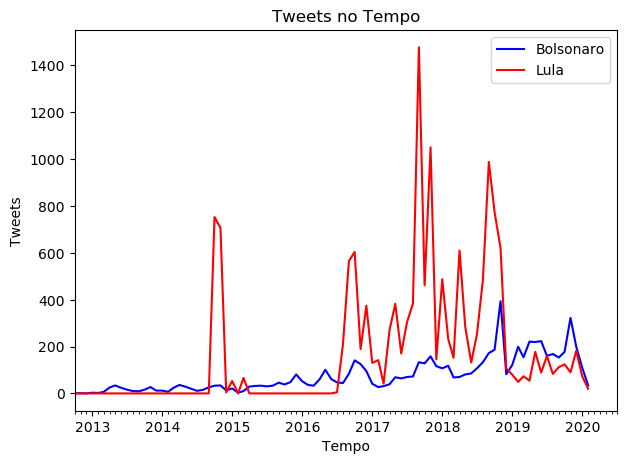

In [123]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator,YearLocator, DateFormatter

figx=7
figy=(8/10)*figx
fig,ax=plt.subplots(figsize=(figx,figy),dpi=100)
# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
# fig, ax = plt.subplots()  # Create a figure and an axes.

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

ax.fmt_xdata = DateFormatter('%Y-%m') # '%Y-%m-%d %H:%M:%S'
fig.autofmt_xdate()

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_xlim([dt.date(2012, 10, 1), dt.date(2020, 7, 1)]) # Fixed range

ax.plot(ctweets['jairbolsonaro'].index.get_level_values(0).to_numpy(), ctweets['jairbolsonaro'].to_numpy(), color='blue', label='Bolsonaro')  # Plot some data on the axes.
ax.plot(ctweets['LulaOficial'].index.get_level_values(0).to_numpy(), ctweets['LulaOficial'].to_numpy(), color='red', label='Lula')

ax.set_xlabel('Tempo')  # Add an x-label to the axes.
ax.set_ylabel('Tweets')  # Add a y-label to the axes.
ax.set_title("Tweets no Tempo")  # Add a title to the axes.
ax.legend()  # Add a legend.

### Palavras mais utilizadas

In [175]:
s = indexed_df.loc['jairbolsonaro', 'palavras'].explode()
s.dropna(inplace=True)
s.value_counts().head(15)

brasil        1268
bolsonaro      810
governo        387
abraço         319
hoje           308
pt             308
dia            278
jair           273
presidente     240
via            226
país           219
vamos          195
estamos        188
há             185
economia       175
Name: palavras, dtype: int64

In [177]:
l = indexed_df.loc['LulaOficial', 'palavras'].explode()
l.dropna(inplace=True)
l.value_counts().head(15)

lula          5349
país          1716
brasil        1487
presidente     933
gente          926
pra            844
governo        656
pt             638
anos           635
hoje           616
vivo           600
dia            594
ricardo        581
stuckert       552
candidato      519
Name: palavras, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
labels, data = zip(*words_freq.most_common(10))

x = np.arange(len(labels))  # the label locations

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequência')
ax.set_title('Palavras mais utilizadas pelo Lula')

plt.bar(x, list(data))
plt.xticks(x, labels, rotation=80)
fig.tight_layout()
plt.show()

In [ ]:
a = [1, 2]

b = 'Cheio' if a else 'Vazio'
b

In [ ]:
df = pd.DataFrame(np.random.randn(3, 8), index=['A', 'B', 'C'], columns=index)

In [ ]:
print(('olá', 1))

# Referências

\[1\] [https://twitter.com](https://twitter.com/)<br>
\[2\] [https://www.facebook.com](https://www.facebook.com/)<br>
\[3\] https://sandbox.anaconda.com/<br>

In [20]:
tweets_df

,created_at,id_str,full_text,truncated,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,quoted_status,tweet_len,word_cnt,profile,hashtags,user_mentions
0,2010-04-01 00:00:00+00:00,11402700435,"EM ""DITADURA"" SEM PAREDÃO, ATÉ CHICO ALENCAR É...",False,30,15,False,False,NaN,NaN,137,24,jairbolsonaro,NaN,NaN
1,2019-01-10 00:00:00+00:00,1083318129135112192,"Bom dia! 🇧🇷 #tbt com o amigo ""Canguru"", que já...",False,1773,31618,False,False,False,NaN,114,21,jairbolsonaro,[tbt],NaN
2,2019-07-19 00:00:00+00:00,1152036400138579968,- Para descontrair. Proibido queimar ovo. (Kkk...,False,5859,46637,False,False,False,NaN,72,10,jairbolsonaro,NaN,NaN
3,2018-10-09 00:00:00+00:00,1049492883328380928,Trecho de entrevista ao vivo para o Jornal Nac...,False,13915,56322,False,False,False,NaN,89,16,jairbolsonaro,NaN,NaN
4,2017-08-23 00:00:00+00:00,900375277557215232,Querem criar o fundão bilionário na Reforma Po...,False,2271,7147,False,False,NaN,NaN,138,21,jairbolsonaro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14956,2014-10-23 00:00:00+00:00,525283408856219648,O prefeito Eduardo Paes e @LindbergFarias acom...,False,19,8,False,False,NaN,NaN,99,11,LulaOficial,"[QueroDilmaTreze, LulanoRJporDilma]",NaN
14957,2018-10-02 00:00:00+00:00,1047114757654884352,"Haddad, o candidato de Lula, com Lindberg sena...",False,52,191,False,False,False,NaN,140,23,LulaOficial,[HaddadP],NaN
14958,2016-07-24 00:00:00+00:00,757229960314617856,"Nádia Campeão: ""não vamos permitir que essa ca...",False,5,12,False,False,NaN,NaN,123,19,LulaOficial,[SPcomHaddad],NaN
14959,2019-06-11 00:00:00+00:00,1138468770232569860,"Os advogados de Lula, Cristiano Zanin e José R...",False,263,1191,False,False,False,NaN,232,39,LulaOficial,NaN,NaN


In [22]:
# indexed_df.xs('11402700435', level=2)
indexed_df

full_text  \
profile       created_at                id_str                                                                   
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610          Boa noite a todos @depchicolanecar @reportercrime   
                                        11398669496          Me desculpem, boa noite @depchicoalencar @repo...   
                                        11399072031          Os militares assumiram o governo em março de 6...   
                                        11399181472          Em 64, o povo ñ suportava + greves, desordem s...   
                                        11399973381          #debate64 O Governo se fez enérgico. Os q pega...   
...                                                                                                        ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578  Na relação internacional sempre são dois inter...   
                                        1214913998346424323  Vamos ter que brigar muito para o Brasil recup...   
                                        1214917269769347075  Agora inventaram uma palavra pra justificar o ...   
                                        1215010265638604800  Bolsonaro, pensa no Brasil e pare de ser puxa ...   
                                        1215011693429952512           Nota à imprensa: https://t.co/tU7cnfrmk5   

                                                             truncated  \
profile       created_at                id_str                           
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610              False   
                                        11398669496              False   
                                        11399072031              False   
                                        11399181472              False   
                                        11399973381              False   
...                                                                ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578      False   
                                        1214913998346424323      False   
                                        1214917269769347075      False   
                                        1215010265638604800      False   
                                        1215011693429952512      False   

                                                             retweet_count  \
profile       created_at                id_str                               
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610                     18   
                                        11398669496                      2   
                                        11399072031                      9   
                                        11399181472                      6   
                                        11399973381                      3   
...                                                                    ...   
LulaOficial   2020-01-08 00:00:00+00:00 1214911118357016578           3165   
                                        1214913998346424323            996   
                                        1214917269769347075           2428   
                                        1215010265638604800           8812   
                                        1215011693429952512           1108   

                                                             favorite_count  \
profile       created_at                id_str                                
jairbolsonaro 2010-04-01 00:00:00+00:00 11398556610                      19   
                                        11398669496                       2   
                                        11399072031                       1   
                                        11399181472                       1   
                                        11399973381                       7   
...                                                                     ...   
LulaOfic

In [170]:
ps = [token for doc in docs for token in doc if  not token.is_stop 
            and not token.is_punct and not token.like_url and not token._.is_hashtag 
            and not token._.is_mention and not token._.is_currency and not token._.is_abrev
            and not token._.is_emoji and not token.is_space]

In [171]:
for i in range(1000):
    print("Token: {0} == Pos: {1}".format(ps[i].text, ps[i].pos_))

Token: noite == Pos: VERB
Token: desculpem == Pos: VERB
Token: noite == Pos: NOUN
Token: militares == Pos: SYM
Token: assumiram == Pos: VERB
Token: governo == Pos: NOUN
Token: março == Pos: NOUN
Token: 64 == Pos: NUM
Token: apelos == Pos: NOUN
Token: imprensa == Pos: NOUN
Token: igreja == Pos: PROPN
Token: católica == Pos: PROPN
Token: mulheres == Pos: PROPN
Token: passeatas == Pos: NOUN
Token: Brasil == Pos: PROPN
Token: 64 == Pos: NUM
Token: suportava == Pos: VERB
Token: greves == Pos: NOUN
Token: desordem == Pos: VERB
Token: social == Pos: ADJ
Token: corrupção == Pos: NOUN
Token: generalizada == Pos: VERB
Token: Governo == Pos: PROPN
Token: enérgico == Pos: NOUN
Token: pegaram == Pos: VERB
Token: armas == Pos: NOUN
Token: acusavam == Pos: VERB
Token: militares == Pos: SYM
Token: violentos == Pos: VERB
Token: buscando == Pos: VERB
Token: votos == Pos: NOUN
Token: indenizações == Pos: NOUN
Token: milionárias == Pos: ADJ
Token: Fidel == Pos: PROPN
Token: castro == Pos: PROPN
Token: fin